## OBJECTIVE : 

### Prepare classification model for classifying comments into various categories : toxic, severe_toxic, obscene, threat, insult, identity_hate

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.2
Pandas Version :  1.0.3
Matplotlib Version :  3.2.1


In [204]:
from joblib import load
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, AlphaDropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Nadam
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [5]:
import utils.text_processing as tp
from config import GLOVE_PATH, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, VALIDATION_SPLIT, BATCH_SIZE, EPOCHS

In [6]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [7]:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data/word_2_index/")

In [8]:
CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
train_data = pd.read_csv(os.path.join(TRAIN_DIR, "vectors_complex.csv"), encoding="utf-8")

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0,0,0,0,0,...,2,2058,16,15,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,697,9,4,91,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,218,571,76,302,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,17,1,680,2996,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2140,677,371,2,0,0,0,0,0,0


In [11]:
X = train_data[[str(i) for i in np.arange(0, 100, 1)]].values
y = train_data[CLASSES].values

In [12]:
X.shape, y.shape

((159356, 100), (159356, 6))

In [13]:
X

array([[   0,    0,    0, ..., 2058,   16,   15],
       [   0,    0,    0, ...,    9,    4,   91],
       [   0,    0,    0, ...,  571,   76,  302],
       ...,
       [   0,    0,    0, ..., 2029, 9403, 2902],
       [   0,    0,    0, ...,  189,   18,   27],
       [   0,    0,    0, ...,  206,   30,  958]])

In [14]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [15]:
tokenizer = load(os.path.join(OBJECT_DIR, "tokenizer.joblib"))

In [16]:
word_ind_dict = tokenizer.word_index

In [17]:
GLOVE_PATH = "/home/praveen/pk_works/nlp/glove"
GLOVE_PATH = os.path.join(GLOVE_PATH, "glove.6B.{}d.txt".format(EMBEDDING_DIM))
GLOVE_PATH

'/home/praveen/pk_works/nlp/glove/glove.6B.100d.txt'

In [18]:
num_words = min(MAX_VOCAB_SIZE, len(word_ind_dict) + 1)

In [19]:
num_words

20000

In [20]:
len(word_ind_dict)

151081

In [21]:
embed_matrix = tp.get_embedding_matrix(GLOVE_PATH, word_ind_dict, num_words, EMBEDDING_DIM, MAX_VOCAB_SIZE)

In [22]:
embed_layer = tp.get_embedding_layer(num_words, EMBEDDING_DIM, embed_matrix, MAX_SEQUENCE_LENGTH)

In [23]:
embed_matrix.shape

(20000, 100)

In [24]:
embed_layer.get_config()

{'name': 'embedding',
 'trainable': False,
 'batch_input_shape': (None, 100),
 'dtype': 'float32',
 'input_dim': 20000,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 100}

In [25]:
num_words, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH

(20000, 100, 100)

In [225]:
def create_model():
    # train a 1D convnet with global maxpooling
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Conv1D(128, 3, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.40)(x)
    x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
#     x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu', kernel_initializer="he_normal")(x)
#     x = AlphaDropout(0.45)(x)
    output = Dense(len(CLASSES), activation='sigmoid')(x)
    model = Model(input_, output)
    return model

In [226]:
model = create_model()

In [227]:
model.get_config()

{'name': 'model_16',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_17'},
   'name': 'input_17',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'input_dim': 20000,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 100},
   'name': 'embedding',
   'inbound_nodes': [[['input_17', 0, 0, {}]]]},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_22',
    'trainable': True,
    'dtype': 'float32',
    'filters': 128,
    'kernel_size': (3,),
    'strides': (1,),
    'padding': 'valid',

In [228]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999),
  metrics=['accuracy']
)

In [229]:
history = model.fit(
  X,
  y,
  batch_size=BATCH_SIZE,
  epochs=5,
  validation_split=VALIDATION_SPLIT
)

Train on 127484 samples, validate on 31872 samples
Epoch 1/5
127484/127484 [==============================] - 5s 40us/sample - loss: 0.0957 - accuracy: 0.9702 - val_loss: 0.0828 - val_accuracy: 0.9742
Epoch 2/5
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0755 - accuracy: 0.9751 - val_loss: 0.0830 - val_accuracy: 0.9750
Epoch 3/5
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0720 - accuracy: 0.9761 - val_loss: 0.0787 - val_accuracy: 0.9756
Epoch 4/5
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0696 - accuracy: 0.9767 - val_loss: 0.0772 - val_accuracy: 0.9749
Epoch 5/5
127484/127484 [==============================] - 5s 37us/sample - loss: 0.0681 - accuracy: 0.9771 - val_loss: 0.0820 - val_accuracy: 0.9758


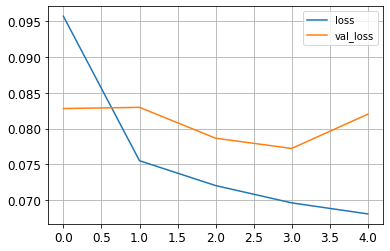

In [230]:
# plot some data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

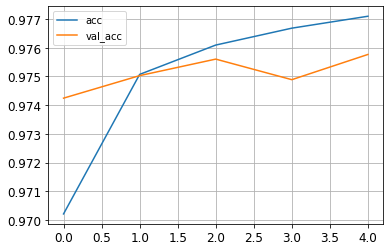

In [231]:
# accuracies
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.show()

In [232]:
# plot the mean AUC over each label
p = model.predict(X)
p = np.where(p > 0.5, 1, 0)
aucs = []
for j in range(6):
    auc = roc_auc_score(y[:,j], p[:,j])
    aucs.append(auc)
print("MEAN auc : ", np.mean(aucs))

MEAN auc :  0.7006658596972409


In [233]:
for i in range(len(CLASSES)):
    print("For class : ", CLASSES[i])
    tn, fp, fn, tp = confusion_matrix(y[:,i], p[:,i]).ravel()
    print("True neg : ", tn)
    print("False pos : ", fp)
    print("False neg : ", fn)
    print("True pos : ", tp)
    print()

For class :  toxic
True neg :  141932
False pos :  2131
False neg :  6277
True pos :  9016

For class :  severe_toxic
True neg :  157608
False pos :  153
False neg :  1304
True pos :  291

For class :  obscene
True neg :  150027
False pos :  880
False neg :  3319
True pos :  5130

For class :  threat
True neg :  158804
False pos :  74
False neg :  361
True pos :  117

For class :  insult
True neg :  149945
False pos :  1534
False neg :  3404
True pos :  4473

For class :  identity_hate
True neg :  157836
False pos :  115
False neg :  1055
True pos :  350



In [234]:
for i in range(len(CLASSES)):
    print("For class : ", CLASSES[i])
    print(classification_report(y[:,i], p[:,i]))
    print()

For class :  toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    144063
           1       0.81      0.59      0.68     15293

    accuracy                           0.95    159356
   macro avg       0.88      0.79      0.83    159356
weighted avg       0.94      0.95      0.94    159356


For class :  severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    157761
           1       0.66      0.18      0.29      1595

    accuracy                           0.99    159356
   macro avg       0.82      0.59      0.64    159356
weighted avg       0.99      0.99      0.99    159356


For class :  obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    150907
           1       0.85      0.61      0.71      8449

    accuracy                           0.97    159356
   macro avg       0.92      0.80      0.85    159356
weight

In [235]:
for i in range(len(CLASSES)):
    print("ROC for CLASS : {} is {}.".format(CLASSES[i], roc_auc_score(y[:, i], p[:, i])))

ROC for CLASS : toxic is 0.7873793176571297.
ROC for CLASS : severe_toxic is 0.5907376598135361.
ROC for CLASS : obscene is 0.8006705201727854.
ROC for CLASS : threat is 0.6221520541458062.
ROC for CLASS : insult is 0.7788644832000067.
ROC for CLASS : identity_hate is 0.6241911231941815.


In [236]:
for i in range(len(CLASSES)):
    print("Precision for CLASS : {} is {}.".format(CLASSES[i], precision_score(y[:, i], p[:, i])))

Precision for CLASS : toxic is 0.8088274872162914.
Precision for CLASS : severe_toxic is 0.6554054054054054.
Precision for CLASS : obscene is 0.8535773710482529.
Precision for CLASS : threat is 0.612565445026178.
Precision for CLASS : insult is 0.7446312635258865.
Precision for CLASS : identity_hate is 0.7526881720430108.


In [237]:
for i in range(len(CLASSES)):
    print("Recall for CLASS : {} is {}.".format(CLASSES[i], recall_score(y[:, i], p[:, i])))

Recall for CLASS : toxic is 0.5895507748643171.
Recall for CLASS : severe_toxic is 0.18244514106583073.
Recall for CLASS : obscene is 0.6071724464433661.
Recall for CLASS : threat is 0.24476987447698745.
Recall for CLASS : insult is 0.5678557826583724.
Recall for CLASS : identity_hate is 0.2491103202846975.
